In [1]:
!pip install --upgrade torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 5.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 11.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 112.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 107.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 8.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 20.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 115.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 59.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 25.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install nibabel

In [3]:
!pip install monai

# 1. CLAHE + Butterworth High-Pass Filter

In [6]:
import os
import numpy as np
import nibabel as nib
from skimage import exposure
from scipy.fftpack import fftn, ifftn, fftshift

# Set up directories
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessing_clahe_butterworth"
os.makedirs(save_dir, exist_ok=True)

# CLAHE (slice-wise)
def apply_clahe_3d(volume, clip_limit=0.01, nbins=256):
    enhanced_volume = np.zeros_like(volume)
    for i in range(volume.shape[2]):
        slice_ = volume[:, :, i]
        slice_norm = (slice_ - slice_.min()) / (slice_.ptp() + 1e-6)
        slice_eq = exposure.equalize_adapthist(slice_norm, clip_limit=clip_limit, nbins=nbins)
        enhanced_volume[:, :, i] = slice_eq * (slice_.ptp() + 1e-6) + slice_.min()
    return enhanced_volume

# Butterworth highpass filter
def butterworth_highpass_filter(volume, cutoff=0.05, order=2):
    shape = volume.shape
    u = np.fft.fftfreq(shape[0])
    v = np.fft.fftfreq(shape[1])
    w = np.fft.fftfreq(shape[2])
    U, V, W = np.meshgrid(u, v, w, indexing='ij')
    d = np.sqrt(U**2 + V**2 + W**2)
    butterworth_filter = 1 / (1 + (cutoff / (d + 1e-6)) ** (2*order))

    volume_fft = fftn(volume)
    volume_fft_shifted = fftshift(volume_fft)
    volume_filtered = volume_fft_shifted * butterworth_filter
    volume_ifft = ifftn(np.fft.ifftshift(volume_filtered)).real
    return volume_ifft

# Process each case
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in case_list:
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_data = nib.load(img_path).get_fdata()
    affine = nib.load(img_path).affine

    # Apply preprocessing
    clahe_img = apply_clahe_3d(img_data)
    butter_img = butterworth_highpass_filter(clahe_img)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(butter_img, affine), save_path)
    print(f"Saved preprocessed {case_num} to {save_path}")

print("All preprocessed images saved in 'preprocessing_1' folder!")


Saved preprocessed 04_43 to /notebooks/elmar/preprocessing_clahe_butterworth/04_43_preprocessed.nii.gz
Saved preprocessed 22_31 to /notebooks/elmar/preprocessing_clahe_butterworth/22_31_preprocessed.nii.gz
Saved preprocessed 04_21 to /notebooks/elmar/preprocessing_clahe_butterworth/04_21_preprocessed.nii.gz
Saved preprocessed 22_58 to /notebooks/elmar/preprocessing_clahe_butterworth/22_58_preprocessed.nii.gz
Saved preprocessed 22_27 to /notebooks/elmar/preprocessing_clahe_butterworth/22_27_preprocessed.nii.gz
Saved preprocessed 22_47 to /notebooks/elmar/preprocessing_clahe_butterworth/22_47_preprocessed.nii.gz
Saved preprocessed 22_50 to /notebooks/elmar/preprocessing_clahe_butterworth/22_50_preprocessed.nii.gz
Saved preprocessed 22_51 to /notebooks/elmar/preprocessing_clahe_butterworth/22_51_preprocessed.nii.gz
Saved preprocessed 04_23 to /notebooks/elmar/preprocessing_clahe_butterworth/04_23_preprocessed.nii.gz
Saved preprocessed 13_35 to /notebooks/elmar/preprocessing_clahe_butterwo

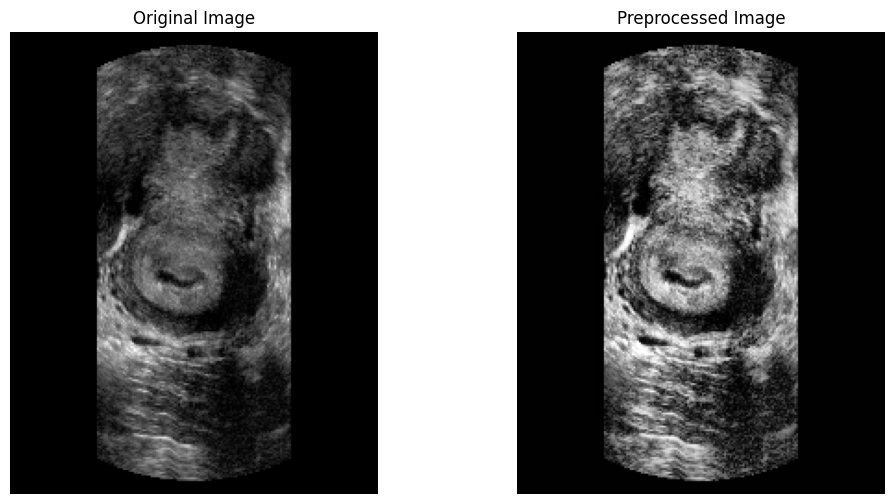

In [10]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Choose one example
case_num = "04_30"  # adjust as needed
original_img_path = f"/notebooks/elmar/uterUS/uterUS_{case_num}/{case_num}_image.nii.gz"
preprocessed_img_path = f"/notebooks/elmar/preprocessing_clahe_butterworth/{case_num}_preprocessed.nii.gz"

# Load images
original_data = nib.load(original_img_path).get_fdata()
preprocessed_data = nib.load(preprocessed_img_path).get_fdata()

# Choose middle slice
#slice_num = original_data.shape[2] // 2
slice_num = 40
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()


# 2. DWT + Threshold

In [11]:
import os
import numpy as np
import nibabel as nib
import pywt

# Set up directories
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessing_dwt_threshold"
os.makedirs(save_dir, exist_ok=True)

# DWT + Threshold (3D)
def dwt_threshold(volume, wavelet='db1', level=1, threshold=0.01):
    # Decompose 3D volume
    coeffs = pywt.wavedecn(volume, wavelet=wavelet, level=level)
    
    # Threshold coefficients
    coeffs_thresh = []
    for coeff in coeffs:
        if isinstance(coeff, dict):
            coeff_thresh = {key: pywt.threshold(c, threshold * np.max(c)) for key, c in coeff.items()}
            coeffs_thresh.append(coeff_thresh)
        else:
            coeffs_thresh.append(coeff)

    # Reconstruct volume
    volume_denoised = pywt.waverecn(coeffs_thresh, wavelet=wavelet)
    return volume_denoised

# Process each case
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in case_list:
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_data = nib.load(img_path).get_fdata()
    affine = nib.load(img_path).affine

    # Apply DWT + Threshold
    dwt_img = dwt_threshold(img_data)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(dwt_img.astype(np.float32), affine), save_path)
    print(f"Saved preprocessed {case_num} to {save_path}")

print("All DWT-threshold preprocessed images saved in 'preprocessing_dwt_threshold' folder!")


Saved preprocessed 04_43 to /notebooks/elmar/preprocessing_dwt_threshold/04_43_preprocessed.nii.gz
Saved preprocessed 22_31 to /notebooks/elmar/preprocessing_dwt_threshold/22_31_preprocessed.nii.gz
Saved preprocessed 04_21 to /notebooks/elmar/preprocessing_dwt_threshold/04_21_preprocessed.nii.gz
Saved preprocessed 22_58 to /notebooks/elmar/preprocessing_dwt_threshold/22_58_preprocessed.nii.gz
Saved preprocessed 22_27 to /notebooks/elmar/preprocessing_dwt_threshold/22_27_preprocessed.nii.gz
Saved preprocessed 22_47 to /notebooks/elmar/preprocessing_dwt_threshold/22_47_preprocessed.nii.gz
Saved preprocessed 22_50 to /notebooks/elmar/preprocessing_dwt_threshold/22_50_preprocessed.nii.gz
Saved preprocessed 22_51 to /notebooks/elmar/preprocessing_dwt_threshold/22_51_preprocessed.nii.gz
Saved preprocessed 04_23 to /notebooks/elmar/preprocessing_dwt_threshold/04_23_preprocessed.nii.gz
Saved preprocessed 13_35 to /notebooks/elmar/preprocessing_dwt_threshold/13_35_preprocessed.nii.gz
Saved prep

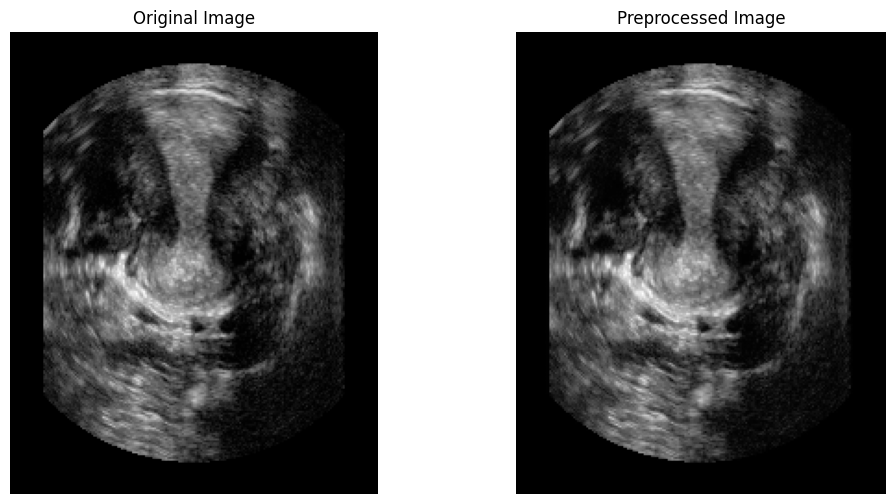

In [13]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Choose one example
case_num = "04_30"  # adjust as needed
original_img_path = f"/notebooks/elmar/uterUS/uterUS_{case_num}/{case_num}_image.nii.gz"
preprocessed_img_path = f"/notebooks/elmar/preprocessing_dwt_threshold/{case_num}_preprocessed.nii.gz"

# Load images
original_data = nib.load(original_img_path).get_fdata()
preprocessed_data = nib.load(preprocessed_img_path).get_fdata()

# Choose middle slice
slice_num = original_data.shape[2] // 2

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()


# 3. CLAHE + Median Filter

In [14]:
import os
import numpy as np
import nibabel as nib
from skimage import exposure
from scipy.ndimage import median_filter

# Set up directories
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessing_clahe_median"
os.makedirs(save_dir, exist_ok=True)

# CLAHE (slice-wise)
def apply_clahe_3d(volume, clip_limit=0.01, nbins=256):
    enhanced_volume = np.zeros_like(volume)
    for i in range(volume.shape[2]):
        slice_ = volume[:, :, i]
        slice_norm = (slice_ - slice_.min()) / (slice_.ptp() + 1e-6)
        slice_eq = exposure.equalize_adapthist(slice_norm, clip_limit=clip_limit, nbins=nbins)
        enhanced_volume[:, :, i] = slice_eq * (slice_.ptp() + 1e-6) + slice_.min()
    return enhanced_volume

# Median Filter
def apply_median_filter(volume, size=3):
    return median_filter(volume, size=size)

# Process each case
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in case_list:
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_data = nib.load(img_path).get_fdata()
    affine = nib.load(img_path).affine

    # Apply CLAHE
    clahe_img = apply_clahe_3d(img_data)

    # Apply Median Filter
    median_img = apply_median_filter(clahe_img, size=3)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(median_img.astype(np.float32), affine), save_path)
    print(f"Saved preprocessed {case_num} to {save_path}")

print("All CLAHE + Median Filter preprocessed images saved in 'preprocessing_clahe_median' folder!")


Saved preprocessed 04_43 to /notebooks/elmar/preprocessing_clahe_median/04_43_preprocessed.nii.gz
Saved preprocessed 22_31 to /notebooks/elmar/preprocessing_clahe_median/22_31_preprocessed.nii.gz
Saved preprocessed 04_21 to /notebooks/elmar/preprocessing_clahe_median/04_21_preprocessed.nii.gz
Saved preprocessed 22_58 to /notebooks/elmar/preprocessing_clahe_median/22_58_preprocessed.nii.gz
Saved preprocessed 22_27 to /notebooks/elmar/preprocessing_clahe_median/22_27_preprocessed.nii.gz
Saved preprocessed 22_47 to /notebooks/elmar/preprocessing_clahe_median/22_47_preprocessed.nii.gz
Saved preprocessed 22_50 to /notebooks/elmar/preprocessing_clahe_median/22_50_preprocessed.nii.gz
Saved preprocessed 22_51 to /notebooks/elmar/preprocessing_clahe_median/22_51_preprocessed.nii.gz
Saved preprocessed 04_23 to /notebooks/elmar/preprocessing_clahe_median/04_23_preprocessed.nii.gz
Saved preprocessed 13_35 to /notebooks/elmar/preprocessing_clahe_median/13_35_preprocessed.nii.gz
Saved preprocessed 1

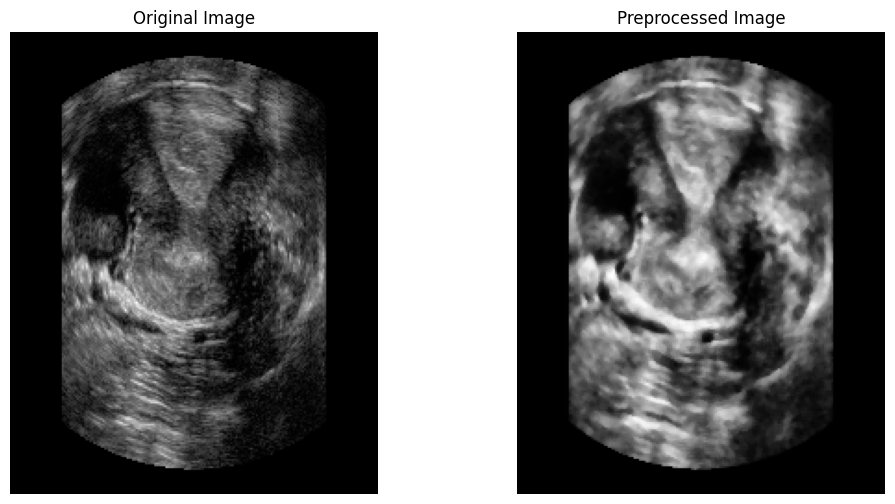

In [16]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Choose one example
case_num = "04_30"  # adjust as needed
original_img_path = f"/notebooks/elmar/uterUS/uterUS_{case_num}/{case_num}_image.nii.gz"
preprocessed_img_path = f"/notebooks/elmar/preprocessing_clahe_median/{case_num}_preprocessed.nii.gz"

# Load images
original_data = nib.load(original_img_path).get_fdata()
preprocessed_data = nib.load(preprocessed_img_path).get_fdata()

# Choose middle slice
#slice_num = original_data.shape[2] // 2
slice_num = 55
# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()


# 4. Median-Mean Hybrid Filter

In [19]:
import os
import numpy as np
import nibabel as nib
from skimage import exposure
from scipy.ndimage import median_filter, uniform_filter

# Set up directories
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessing_median_mean"
os.makedirs(save_dir, exist_ok=True)

# CLAHE (slice-wise)
def apply_clahe_3d(volume, clip_limit=0.01, nbins=256):
    enhanced_volume = np.zeros_like(volume)
    for i in range(volume.shape[2]):
        slice_ = volume[:, :, i]
        slice_norm = (slice_ - slice_.min()) / (slice_.ptp() + 1e-6)
        slice_eq = exposure.equalize_adapthist(slice_norm, clip_limit=clip_limit, nbins=nbins)
        enhanced_volume[:, :, i] = slice_eq * (slice_.ptp() + 1e-6) + slice_.min()
    return enhanced_volume

# Median-Mean Hybrid Filter (3D)
def median_mean_hybrid_filter(volume, median_size=3, mean_size=3):
    median_filtered = median_filter(volume, size=median_size)
    mean_filtered = uniform_filter(volume, size=mean_size)
    hybrid = (median_filtered + mean_filtered) / 2.0
    return hybrid

# Process each case
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in case_list:
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_data = nib.load(img_path).get_fdata()
    affine = nib.load(img_path).affine

    # Apply CLAHE
    clahe_img = apply_clahe_3d(img_data)

    # Apply Median-Mean Hybrid filter
    hybrid_img = median_mean_hybrid_filter(clahe_img, median_size=3, mean_size=3)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(hybrid_img.astype(np.float32), affine), save_path)
    print(f"Saved preprocessed {case_num} to {save_path}")

print("All Median-Mean Hybrid preprocessed images saved in 'preprocessing_median_mean' folder!")

Saved preprocessed 04_43 to /notebooks/elmar/preprocessing_median_mean/04_43_preprocessed.nii.gz
Saved preprocessed 22_31 to /notebooks/elmar/preprocessing_median_mean/22_31_preprocessed.nii.gz
Saved preprocessed 04_21 to /notebooks/elmar/preprocessing_median_mean/04_21_preprocessed.nii.gz
Saved preprocessed 22_58 to /notebooks/elmar/preprocessing_median_mean/22_58_preprocessed.nii.gz
Saved preprocessed 22_27 to /notebooks/elmar/preprocessing_median_mean/22_27_preprocessed.nii.gz
Saved preprocessed 22_47 to /notebooks/elmar/preprocessing_median_mean/22_47_preprocessed.nii.gz
Saved preprocessed 22_50 to /notebooks/elmar/preprocessing_median_mean/22_50_preprocessed.nii.gz
Saved preprocessed 22_51 to /notebooks/elmar/preprocessing_median_mean/22_51_preprocessed.nii.gz
Saved preprocessed 04_23 to /notebooks/elmar/preprocessing_median_mean/04_23_preprocessed.nii.gz
Saved preprocessed 13_35 to /notebooks/elmar/preprocessing_median_mean/13_35_preprocessed.nii.gz
Saved preprocessed 13_03 to /n

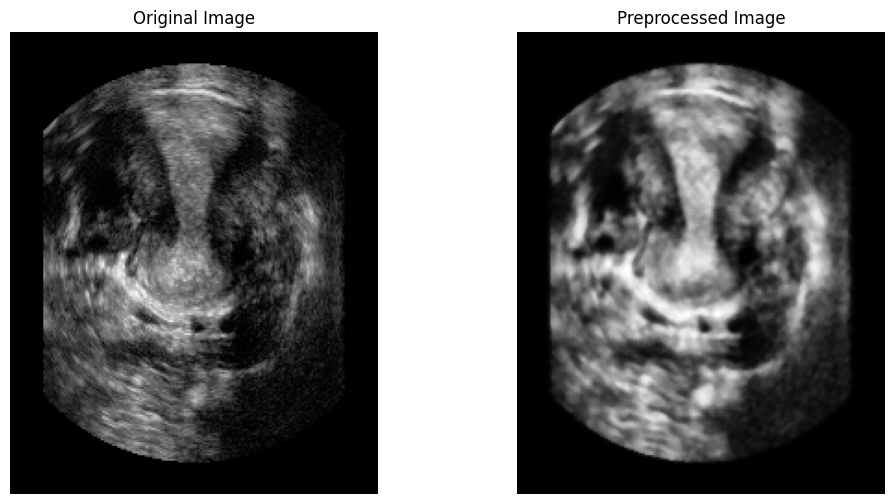

In [20]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Choose one example
case_num = "04_30"  # adjust as needed
original_img_path = f"/notebooks/elmar/uterUS/uterUS_{case_num}/{case_num}_image.nii.gz"
preprocessed_img_path = f"/notebooks/elmar/preprocessing_median_mean/{case_num}_preprocessed.nii.gz"

# Load images
original_data = nib.load(original_img_path).get_fdata()
preprocessed_data = nib.load(preprocessed_img_path).get_fdata()

# Choose middle slice
slice_num = original_data.shape[2] // 2

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()


# 5. Unsharp Masking + Bilateral Filter

In [21]:
import os
import numpy as np
import nibabel as nib
from skimage import exposure
from scipy.ndimage import gaussian_filter
import cv2

# Set up directories
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessing_unsharp_bilateral"
os.makedirs(save_dir, exist_ok=True)

# CLAHE (slice-wise)
def apply_clahe_3d(volume, clip_limit=0.01, nbins=256):
    enhanced_volume = np.zeros_like(volume)
    for i in range(volume.shape[2]):
        slice_ = volume[:, :, i]
        slice_norm = (slice_ - slice_.min()) / (slice_.ptp() + 1e-6)
        slice_eq = exposure.equalize_adapthist(slice_norm, clip_limit=clip_limit, nbins=nbins)
        enhanced_volume[:, :, i] = slice_eq * (slice_.ptp() + 1e-6) + slice_.min()
    return enhanced_volume

# Unsharp Masking (3D)
def unsharp_mask_3d(volume, sigma=1.0, amount=1.0):
    blurred = gaussian_filter(volume, sigma=sigma)
    sharpened = volume + amount * (volume - blurred)
    return sharpened

# Bilateral Filter (slice-wise using OpenCV)
def bilateral_filter_3d(volume, d=5, sigma_color=75, sigma_space=75):
    filtered_volume = np.zeros_like(volume)
    for i in range(volume.shape[2]):
        slice_ = volume[:, :, i]
        # Normalize to 0-255 for OpenCV
        slice_norm = cv2.normalize(slice_, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        bilateral_filtered = cv2.bilateralFilter(slice_norm, d=d, sigmaColor=sigma_color, sigmaSpace=sigma_space)
        # Scale back to original intensity range
        bilateral_filtered = cv2.normalize(bilateral_filtered.astype(np.float32), None, slice_.min(), slice_.max(), cv2.NORM_MINMAX)
        filtered_volume[:, :, i] = bilateral_filtered
    return filtered_volume

# Process each case
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in case_list:
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_data = nib.load(img_path).get_fdata()
    affine = nib.load(img_path).affine

    # Apply CLAHE
    clahe_img = apply_clahe_3d(img_data)

    # Apply Unsharp Masking
    unsharp_img = unsharp_mask_3d(clahe_img, sigma=1.0, amount=1.0)

    # Apply Bilateral Filter
    final_img = bilateral_filter_3d(unsharp_img, d=5, sigma_color=75, sigma_space=75)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(final_img.astype(np.float32), affine), save_path)
    print(f"Saved preprocessed {case_num} to {save_path}")

print("All Unsharp Masking + Bilateral Filter preprocessed images saved in 'preprocessing_unsharp_bilateral' folder!")


Saved preprocessed 04_43 to /notebooks/elmar/preprocessing_unsharp_bilateral/04_43_preprocessed.nii.gz
Saved preprocessed 22_31 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_31_preprocessed.nii.gz
Saved preprocessed 04_21 to /notebooks/elmar/preprocessing_unsharp_bilateral/04_21_preprocessed.nii.gz
Saved preprocessed 22_58 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_58_preprocessed.nii.gz
Saved preprocessed 22_27 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_27_preprocessed.nii.gz
Saved preprocessed 22_47 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_47_preprocessed.nii.gz
Saved preprocessed 22_50 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_50_preprocessed.nii.gz
Saved preprocessed 22_51 to /notebooks/elmar/preprocessing_unsharp_bilateral/22_51_preprocessed.nii.gz
Saved preprocessed 04_23 to /notebooks/elmar/preprocessing_unsharp_bilateral/04_23_preprocessed.nii.gz
Saved preprocessed 13_35 to /notebooks/elmar/preprocessing_unsharp_bilate

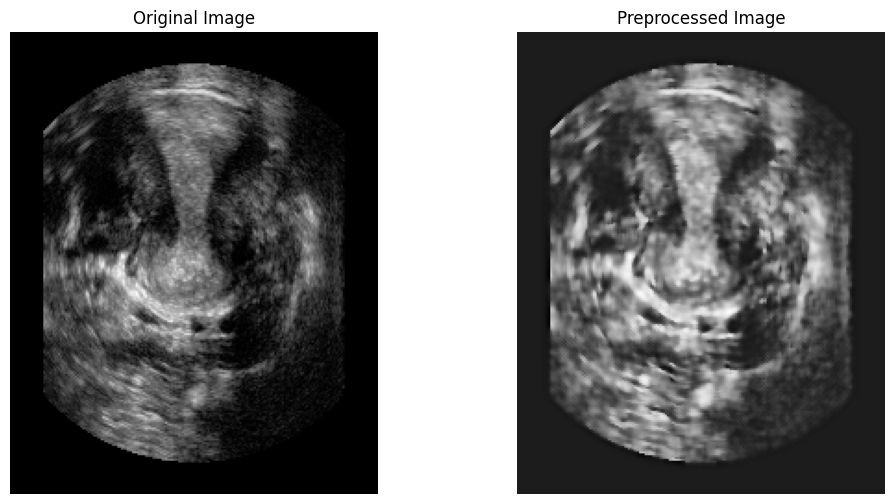

In [22]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

# Choose one example
case_num = "04_30"  # adjust as needed
original_img_path = f"/notebooks/elmar/uterUS/uterUS_{case_num}/{case_num}_image.nii.gz"
preprocessed_img_path = f"/notebooks/elmar/preprocessing_unsharp_bilateral/{case_num}_preprocessed.nii.gz"

# Load images
original_data = nib.load(original_img_path).get_fdata()
preprocessed_data = nib.load(preprocessed_img_path).get_fdata()

# Choose middle slice
slice_num = original_data.shape[2] // 2

# Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Preprocessed Image")
plt.imshow(preprocessed_data[:, :, slice_num], cmap="gray")
plt.axis("off")

plt.show()

# Perona Malik

In [4]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

# --- Anisotropic Diffusion Function ---
def anisotropic_diffusion_3d(volume, num_iter=15, kappa=10, gamma=0.05, option=1):
    vol = volume.astype(np.float32)
    for _ in range(num_iter):
        deltaN = np.roll(vol, -1, axis=0) - vol
        deltaS = np.roll(vol,  1, axis=0) - vol
        deltaE = np.roll(vol, -1, axis=1) - vol
        deltaW = np.roll(vol,  1, axis=1) - vol
        deltaU = np.roll(vol, -1, axis=2) - vol
        deltaD = np.roll(vol,  1, axis=2) - vol

        if option == 1:
            cN = np.exp(-(deltaN / kappa) ** 2)
            cS = np.exp(-(deltaS / kappa) ** 2)
            cE = np.exp(-(deltaE / kappa) ** 2)
            cW = np.exp(-(deltaW / kappa) ** 2)
            cU = np.exp(-(deltaU / kappa) ** 2)
            cD = np.exp(-(deltaD / kappa) ** 2)
        elif option == 2:
            cN = 1.0 / (1.0 + (deltaN / kappa) ** 2)
            cS = 1.0 / (1.0 + (deltaS / kappa) ** 2)
            cE = 1.0 / (1.0 + (deltaE / kappa) ** 2)
            cW = 1.0 / (1.0 + (deltaW / kappa) ** 2)
            cU = 1.0 / (1.0 + (deltaU / kappa) ** 2)
            cD = 1.0 / (1.0 + (deltaD / kappa) ** 2)

        vol += gamma * (
            cN * deltaN + cS * deltaS +
            cE * deltaE + cW * deltaW +
            cU * deltaU + cD * deltaD
        )
    return vol

# --- Paths ---
data_dir = "/notebooks/elmar/uterUS"
save_dir = "/notebooks/elmar/preprocessed_PM"
os.makedirs(save_dir, exist_ok=True)

# --- Iterate through all cases ---
# List all cases
case_list = [f for f in os.listdir(data_dir) if f.startswith("uterUS_")]
for case_folder in sorted(case_list):
    case_num = case_folder.replace("uterUS_", "")  # e.g., "04_01"
    img_path = os.path.join(data_dir, case_folder, f"{case_num}_image.nii.gz")

    if not os.path.exists(img_path):
        print(f"Missing image for {case_folder}. Skipping.")
        continue

    # Load
    img_nib = nib.load(img_path)
    img_data = img_nib.get_fdata()
    affine = img_nib.affine

    # Apply Anisotropic Diffusion
    denoised_img = anisotropic_diffusion_3d(img_data, num_iter=15, kappa=10, gamma=0.05, option=1)

    # Save
    save_path = os.path.join(save_dir, f"{case_num}_preprocessed.nii.gz")
    nib.save(nib.Nifti1Image(denoised_img, affine), save_path)
    print(f"Saved denoised {case_num} to {save_path}")

print("All denoised images saved in anisotropic diffusion batch run!")



Saved denoised 04_21 to /notebooks/elmar/preprocessed_PM/04_21_preprocessed.nii.gz
Saved denoised 04_22 to /notebooks/elmar/preprocessed_PM/04_22_preprocessed.nii.gz
Saved denoised 04_23 to /notebooks/elmar/preprocessed_PM/04_23_preprocessed.nii.gz
Saved denoised 04_24 to /notebooks/elmar/preprocessed_PM/04_24_preprocessed.nii.gz
Saved denoised 04_25 to /notebooks/elmar/preprocessed_PM/04_25_preprocessed.nii.gz
Saved denoised 04_26 to /notebooks/elmar/preprocessed_PM/04_26_preprocessed.nii.gz
Saved denoised 04_28 to /notebooks/elmar/preprocessed_PM/04_28_preprocessed.nii.gz
Saved denoised 04_30 to /notebooks/elmar/preprocessed_PM/04_30_preprocessed.nii.gz
Saved denoised 04_31 to /notebooks/elmar/preprocessed_PM/04_31_preprocessed.nii.gz
Saved denoised 04_34 to /notebooks/elmar/preprocessed_PM/04_34_preprocessed.nii.gz
Saved denoised 04_35 to /notebooks/elmar/preprocessed_PM/04_35_preprocessed.nii.gz
Saved denoised 04_39 to /notebooks/elmar/preprocessed_PM/04_39_preprocessed.nii.gz
Save

#  DnCNN-3D Model Definition

In [3]:
import torch
import torch.nn as nn

class DnCNN3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, num_features=32, num_layers=10):
        super(DnCNN3D, self).__init__()
        layers = []

        # First layer (conv + ReLU)
        layers.append(nn.Conv3d(in_channels, num_features, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))

        # Intermediate layers (conv + batch norm + ReLU)
        for _ in range(num_layers - 2):
            layers.append(nn.Conv3d(num_features, num_features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm3d(num_features))
            layers.append(nn.ReLU(inplace=True))

        # Last layer (conv only)
        layers.append(nn.Conv3d(num_features, out_channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        noise = self.dncnn(x)
        return x - noise  # Predict residual noise and subtract from input


In [4]:
from torch.utils.data import Dataset
import nibabel as nib
import os
import numpy as np

class NiftiDnCNN3DDataset(Dataset):
    def __init__(self, data_dir):
        self.file_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith(".nii.gz")])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img = nib.load(self.file_paths[idx]).get_fdata()
        img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-8)  # Normalize to [0, 1]
        img = img.astype(np.float32)
        noisy = img + 0.05 * np.random.randn(*img.shape).astype(np.float32)  # Add synthetic Gaussian noise

        return torch.from_numpy(noisy[None, ...]), torch.from_numpy(img[None, ...])  # (1, D, H, W)


In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim
import os
import torch
import torch.nn as nn

# --- Dataset & DataLoader ---
dataset = NiftiDnCNN3DDataset("/notebooks/elmar/preprocessing_clahe_butterworth")
loader = DataLoader(dataset, batch_size=1, shuffle=True)

# --- DnCNN3D Model Definition ---
class DnCNN3D(nn.Module):
    def __init__(self, channels=1, num_of_layers=10, features=32):
        super(DnCNN3D, self).__init__()
        layers = []

        layers.append(nn.Conv3d(channels, features, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv3d(features, features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm3d(features))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv3d(features, channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        out = self.dncnn(x)
        return x - out  # residual learning

# --- Model, Loss, Optimizer ---
model = DnCNN3D().to("cuda")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# --- Training Loop ---
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for noisy, clean in loader:
        noisy, clean = noisy.to("cuda"), clean.to("cuda")
        optimizer.zero_grad()
        denoised = model(noisy)
        loss = criterion(denoised, clean)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(loader):.4f}")

# --- Save Model ---
save_path = "/notebooks/elmar/dncnn3d_model2.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Epoch 1, Loss: 0.0099
Epoch 2, Loss: 0.0022
Epoch 3, Loss: 0.0015
Epoch 4, Loss: 0.0013
Epoch 5, Loss: 0.0012
Epoch 6, Loss: 0.0012
Epoch 7, Loss: 0.0012
Epoch 8, Loss: 0.0011
Epoch 9, Loss: 0.0011
Epoch 10, Loss: 0.0011
Epoch 11, Loss: 0.0011
Epoch 12, Loss: 0.0011
Epoch 13, Loss: 0.0010
Epoch 14, Loss: 0.0010
Epoch 15, Loss: 0.0010
Epoch 16, Loss: 0.0010
Epoch 17, Loss: 0.0010
Epoch 18, Loss: 0.0010
Epoch 19, Loss: 0.0009
Epoch 20, Loss: 0.0009
Epoch 21, Loss: 0.0009
Epoch 22, Loss: 0.0009
Epoch 23, Loss: 0.0009
Epoch 24, Loss: 0.0009
Epoch 25, Loss: 0.0009
Epoch 26, Loss: 0.0009
Epoch 27, Loss: 0.0009
Epoch 28, Loss: 0.0009
Epoch 29, Loss: 0.0009
Epoch 30, Loss: 0.0009
Epoch 31, Loss: 0.0009
Epoch 32, Loss: 0.0009
Epoch 33, Loss: 0.0009
Epoch 34, Loss: 0.0009
Epoch 35, Loss: 0.0009
Epoch 36, Loss: 0.0009
Epoch 37, Loss: 0.0008
Epoch 38, Loss: 0.0008
Epoch 39, Loss: 0.0008
Epoch 40, Loss: 0.0008
Epoch 41, Loss: 0.0008
Epoch 42, Loss: 0.0008
Epoch 43, Loss: 0.0008
Epoch 44, Loss: 0.00

In [5]:
import os
import torch
import nibabel as nib
import numpy as np
from torch.utils.data import Dataset
import torch.nn as nn
from tqdm import tqdm

# --- DnCNN3D model (same as during training) ---
class DnCNN3D(nn.Module):
    def __init__(self, channels=1, num_of_layers=10, features=32):
        super(DnCNN3D, self).__init__()
        layers = []

        layers.append(nn.Conv3d(channels, features, kernel_size=3, padding=1, bias=False))
        layers.append(nn.ReLU(inplace=True))

        for _ in range(num_of_layers - 2):
            layers.append(nn.Conv3d(features, features, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm3d(features))
            layers.append(nn.ReLU(inplace=True))

        layers.append(nn.Conv3d(features, channels, kernel_size=3, padding=1, bias=False))

        self.dncnn = nn.Sequential(*layers)

    def forward(self, x):
        return x - self.dncnn(x)

# --- Load model ---
model = DnCNN3D().to("cuda")
model.load_state_dict(torch.load("/notebooks/elmar/dncnn3d_model2.pth"))
model.eval()

# --- Input/output paths ---
input_dir = "/notebooks/elmar/preprocessing_clahe_butterworth"
output_dir = "/notebooks/elmar/denoised_dncnn3d2"
os.makedirs(output_dir, exist_ok=True)

# --- Denoise all volumes ---
with torch.no_grad():
    for fname in tqdm(sorted(os.listdir(input_dir))):
        if not fname.endswith(".nii.gz"):
            continue
        
        input_path = os.path.join(input_dir, fname)
        img = nib.load(input_path)
        img_data = img.get_fdata().astype(np.float32)

        # Ensure correct shape and normalization
        input_tensor = torch.from_numpy(img_data).unsqueeze(0).unsqueeze(0).to("cuda")  # shape: (1, 1, D, H, W)

        denoised_tensor = model(input_tensor)
        denoised_np = denoised_tensor.squeeze().cpu().numpy()

        # Save denoised volume
        save_path = os.path.join(output_dir, fname.replace(".nii.gz", "_denoised.nii.gz"))
        nib.save(nib.Nifti1Image(denoised_np, affine=img.affine), save_path)
        print(f"Saved: {save_path}")


  1%|          | 1/119 [00:01<03:55,  2.00s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_21_preprocessed_denoised.nii.gz


  2%|▏         | 2/119 [00:03<03:05,  1.59s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_22_preprocessed_denoised.nii.gz


  3%|▎         | 3/119 [00:05<03:31,  1.82s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_23_preprocessed_denoised.nii.gz


  3%|▎         | 4/119 [00:07<03:42,  1.93s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_24_preprocessed_denoised.nii.gz


  4%|▍         | 5/119 [00:09<03:34,  1.88s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_25_preprocessed_denoised.nii.gz


  5%|▌         | 6/119 [00:11<03:40,  1.95s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_26_preprocessed_denoised.nii.gz


  6%|▌         | 7/119 [00:13<03:40,  1.97s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_28_preprocessed_denoised.nii.gz


  7%|▋         | 8/119 [00:14<03:18,  1.79s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_30_preprocessed_denoised.nii.gz


  8%|▊         | 9/119 [00:16<03:20,  1.83s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_31_preprocessed_denoised.nii.gz


  8%|▊         | 10/119 [00:18<03:02,  1.67s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_34_preprocessed_denoised.nii.gz


  9%|▉         | 11/119 [00:19<02:47,  1.55s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_35_preprocessed_denoised.nii.gz


 10%|█         | 12/119 [00:20<02:50,  1.59s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_39_preprocessed_denoised.nii.gz


 11%|█         | 13/119 [00:23<03:03,  1.73s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_40_preprocessed_denoised.nii.gz


 12%|█▏        | 14/119 [00:24<02:48,  1.60s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_41_preprocessed_denoised.nii.gz


 13%|█▎        | 15/119 [00:26<02:57,  1.71s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_42_preprocessed_denoised.nii.gz


 13%|█▎        | 16/119 [00:27<02:50,  1.66s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_43_preprocessed_denoised.nii.gz


 14%|█▍        | 17/119 [00:30<03:05,  1.82s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_44_preprocessed_denoised.nii.gz


 15%|█▌        | 18/119 [00:32<03:11,  1.89s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_46_preprocessed_denoised.nii.gz


 16%|█▌        | 19/119 [00:34<03:18,  1.98s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_47_preprocessed_denoised.nii.gz


 17%|█▋        | 20/119 [00:36<03:10,  1.92s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_48_preprocessed_denoised.nii.gz


 18%|█▊        | 21/119 [00:38<03:14,  1.98s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/04_49_preprocessed_denoised.nii.gz


 18%|█▊        | 22/119 [00:40<03:23,  2.09s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_01_preprocessed_denoised.nii.gz


 19%|█▉        | 23/119 [00:42<03:05,  1.94s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_02_preprocessed_denoised.nii.gz


 20%|██        | 24/119 [00:44<03:05,  1.95s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_03_preprocessed_denoised.nii.gz


 21%|██        | 25/119 [00:45<02:48,  1.79s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_04_preprocessed_denoised.nii.gz


 22%|██▏       | 26/119 [00:46<02:33,  1.65s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_05_preprocessed_denoised.nii.gz


 23%|██▎       | 27/119 [00:48<02:24,  1.57s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_06_preprocessed_denoised.nii.gz


 24%|██▎       | 28/119 [00:50<02:34,  1.70s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_08_preprocessed_denoised.nii.gz


 24%|██▍       | 29/119 [00:52<02:56,  1.96s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_09_preprocessed_denoised.nii.gz


 25%|██▌       | 30/119 [00:54<02:37,  1.77s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_10_preprocessed_denoised.nii.gz


 26%|██▌       | 31/119 [00:56<02:42,  1.85s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_11_preprocessed_denoised.nii.gz


 27%|██▋       | 32/119 [00:58<02:46,  1.91s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_12_preprocessed_denoised.nii.gz


 28%|██▊       | 33/119 [01:00<02:43,  1.90s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_13_preprocessed_denoised.nii.gz


 29%|██▊       | 34/119 [01:02<02:43,  1.92s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_14_preprocessed_denoised.nii.gz


 29%|██▉       | 35/119 [01:02<02:12,  1.57s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_15_preprocessed_denoised.nii.gz


 30%|███       | 36/119 [01:04<02:22,  1.71s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_16_preprocessed_denoised.nii.gz


 31%|███       | 37/119 [01:06<02:28,  1.81s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_18_preprocessed_denoised.nii.gz


 32%|███▏      | 38/119 [01:08<02:23,  1.78s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_19_preprocessed_denoised.nii.gz


 33%|███▎      | 39/119 [01:10<02:28,  1.86s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_20_preprocessed_denoised.nii.gz


 34%|███▎      | 40/119 [01:11<02:12,  1.68s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_21_preprocessed_denoised.nii.gz


 34%|███▍      | 41/119 [01:13<02:17,  1.76s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_22_preprocessed_denoised.nii.gz


 35%|███▌      | 42/119 [01:15<02:07,  1.65s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_23_preprocessed_denoised.nii.gz


 36%|███▌      | 43/119 [01:16<01:47,  1.42s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_24_preprocessed_denoised.nii.gz


 37%|███▋      | 44/119 [01:16<01:34,  1.26s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_25_preprocessed_denoised.nii.gz


 38%|███▊      | 45/119 [01:17<01:19,  1.07s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_26_preprocessed_denoised.nii.gz


 39%|███▊      | 46/119 [01:18<01:10,  1.04it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_27_preprocessed_denoised.nii.gz


 39%|███▉      | 47/119 [01:19<01:14,  1.04s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_28_preprocessed_denoised.nii.gz


 40%|████      | 48/119 [01:20<01:18,  1.11s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_29_preprocessed_denoised.nii.gz


 41%|████      | 49/119 [01:21<01:09,  1.00it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_30_preprocessed_denoised.nii.gz


 42%|████▏     | 50/119 [01:22<01:14,  1.08s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_31_preprocessed_denoised.nii.gz


 43%|████▎     | 51/119 [01:23<01:07,  1.00it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_32_preprocessed_denoised.nii.gz


 44%|████▎     | 52/119 [01:25<01:31,  1.37s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_34_preprocessed_denoised.nii.gz


 45%|████▍     | 53/119 [01:27<01:36,  1.47s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_35_preprocessed_denoised.nii.gz


 45%|████▌     | 54/119 [01:29<01:36,  1.48s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_36_preprocessed_denoised.nii.gz


 46%|████▌     | 55/119 [01:30<01:30,  1.42s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_37_preprocessed_denoised.nii.gz


 47%|████▋     | 56/119 [01:32<01:39,  1.58s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_38_preprocessed_denoised.nii.gz


 48%|████▊     | 57/119 [01:33<01:33,  1.50s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_39_preprocessed_denoised.nii.gz


 49%|████▊     | 58/119 [01:34<01:16,  1.26s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_40_preprocessed_denoised.nii.gz


 50%|████▉     | 59/119 [01:34<00:58,  1.03it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_41_preprocessed_denoised.nii.gz


 50%|█████     | 60/119 [01:35<01:02,  1.06s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_42_preprocessed_denoised.nii.gz


 51%|█████▏    | 61/119 [01:37<01:02,  1.07s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_44_preprocessed_denoised.nii.gz


 52%|█████▏    | 62/119 [01:38<01:07,  1.19s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_45_preprocessed_denoised.nii.gz


 53%|█████▎    | 63/119 [01:39<01:02,  1.12s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_46_preprocessed_denoised.nii.gz


 54%|█████▍    | 64/119 [01:41<01:15,  1.38s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/13_47_preprocessed_denoised.nii.gz


 55%|█████▍    | 65/119 [01:42<01:02,  1.16s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_01_preprocessed_denoised.nii.gz


 55%|█████▌    | 66/119 [01:42<00:51,  1.03it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_02_preprocessed_denoised.nii.gz


 56%|█████▋    | 67/119 [01:43<00:49,  1.06it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_03_preprocessed_denoised.nii.gz


 57%|█████▋    | 68/119 [01:44<00:43,  1.16it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_04_preprocessed_denoised.nii.gz


 58%|█████▊    | 69/119 [01:44<00:40,  1.25it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_05_preprocessed_denoised.nii.gz


 59%|█████▉    | 70/119 [01:46<00:47,  1.04it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_07_preprocessed_denoised.nii.gz


 60%|█████▉    | 71/119 [01:46<00:42,  1.14it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_08_preprocessed_denoised.nii.gz


 61%|██████    | 72/119 [01:47<00:37,  1.25it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_09_preprocessed_denoised.nii.gz


 61%|██████▏   | 73/119 [01:48<00:41,  1.11it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_10_preprocessed_denoised.nii.gz


 62%|██████▏   | 74/119 [01:48<00:31,  1.42it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_11_preprocessed_denoised.nii.gz


 63%|██████▎   | 75/119 [01:49<00:28,  1.52it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_12_preprocessed_denoised.nii.gz


 64%|██████▍   | 76/119 [01:49<00:27,  1.58it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_13_preprocessed_denoised.nii.gz


 65%|██████▍   | 77/119 [01:50<00:25,  1.68it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_14_preprocessed_denoised.nii.gz


 66%|██████▌   | 78/119 [01:50<00:21,  1.90it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_15_preprocessed_denoised.nii.gz


 66%|██████▋   | 79/119 [01:51<00:21,  1.88it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_16_preprocessed_denoised.nii.gz


 67%|██████▋   | 80/119 [01:51<00:21,  1.82it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_17_preprocessed_denoised.nii.gz


 68%|██████▊   | 81/119 [01:52<00:19,  1.91it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_18_preprocessed_denoised.nii.gz


 69%|██████▉   | 82/119 [01:53<00:23,  1.58it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_19_preprocessed_denoised.nii.gz


 70%|██████▉   | 83/119 [01:53<00:18,  1.94it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_20_preprocessed_denoised.nii.gz


 71%|███████   | 84/119 [01:54<00:18,  1.94it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_21_preprocessed_denoised.nii.gz


 71%|███████▏  | 85/119 [01:54<00:17,  1.97it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_22_preprocessed_denoised.nii.gz


 72%|███████▏  | 86/119 [01:55<00:16,  2.00it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_23_preprocessed_denoised.nii.gz


 73%|███████▎  | 87/119 [01:55<00:17,  1.79it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_24_preprocessed_denoised.nii.gz


 74%|███████▍  | 88/119 [01:56<00:16,  1.87it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_25_preprocessed_denoised.nii.gz


 75%|███████▍  | 89/119 [01:57<00:19,  1.57it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_26_preprocessed_denoised.nii.gz


 76%|███████▌  | 90/119 [01:57<00:19,  1.48it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_27_preprocessed_denoised.nii.gz


 76%|███████▋  | 91/119 [01:58<00:20,  1.34it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_28_preprocessed_denoised.nii.gz


 77%|███████▋  | 92/119 [01:59<00:17,  1.51it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_31_preprocessed_denoised.nii.gz


 78%|███████▊  | 93/119 [01:59<00:16,  1.58it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_32_preprocessed_denoised.nii.gz


 79%|███████▉  | 94/119 [02:00<00:15,  1.64it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_33_preprocessed_denoised.nii.gz


 80%|███████▉  | 95/119 [02:01<00:17,  1.39it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_34_preprocessed_denoised.nii.gz


 81%|████████  | 96/119 [02:01<00:14,  1.56it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_35_preprocessed_denoised.nii.gz


 82%|████████▏ | 97/119 [02:02<00:13,  1.67it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_36_preprocessed_denoised.nii.gz


 82%|████████▏ | 98/119 [02:02<00:10,  1.93it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_37_preprocessed_denoised.nii.gz


 83%|████████▎ | 99/119 [02:03<00:10,  1.94it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_38_preprocessed_denoised.nii.gz


 84%|████████▍ | 100/119 [02:03<00:08,  2.31it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_40_preprocessed_denoised.nii.gz


 85%|████████▍ | 101/119 [02:04<00:09,  1.85it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_41_preprocessed_denoised.nii.gz


 86%|████████▌ | 102/119 [02:04<00:09,  1.82it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_42_preprocessed_denoised.nii.gz


 87%|████████▋ | 103/119 [02:05<00:08,  1.88it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_43_preprocessed_denoised.nii.gz


 87%|████████▋ | 104/119 [02:05<00:08,  1.76it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_44_preprocessed_denoised.nii.gz


 88%|████████▊ | 105/119 [02:06<00:08,  1.73it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_45_preprocessed_denoised.nii.gz


 89%|████████▉ | 106/119 [02:07<00:07,  1.64it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_46_preprocessed_denoised.nii.gz


 90%|████████▉ | 107/119 [02:07<00:06,  1.79it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_47_preprocessed_denoised.nii.gz


 91%|█████████ | 108/119 [02:08<00:05,  1.84it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_48_preprocessed_denoised.nii.gz


 92%|█████████▏| 109/119 [02:08<00:06,  1.63it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_49_preprocessed_denoised.nii.gz


 92%|█████████▏| 110/119 [02:09<00:05,  1.76it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_50_preprocessed_denoised.nii.gz


 93%|█████████▎| 111/119 [02:10<00:04,  1.64it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_51_preprocessed_denoised.nii.gz


 94%|█████████▍| 112/119 [02:10<00:03,  1.85it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_52_preprocessed_denoised.nii.gz


 95%|█████████▍| 113/119 [02:10<00:03,  1.97it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_53_preprocessed_denoised.nii.gz


 96%|█████████▌| 114/119 [02:11<00:03,  1.62it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_54_preprocessed_denoised.nii.gz


 97%|█████████▋| 115/119 [02:12<00:02,  1.59it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_55_preprocessed_denoised.nii.gz


 97%|█████████▋| 116/119 [02:12<00:01,  1.64it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_56_preprocessed_denoised.nii.gz


 98%|█████████▊| 117/119 [02:13<00:01,  1.85it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_57_preprocessed_denoised.nii.gz


 99%|█████████▉| 118/119 [02:13<00:00,  1.96it/s]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_58_preprocessed_denoised.nii.gz


100%|██████████| 119/119 [02:14<00:00,  1.13s/it]

Saved: /notebooks/elmar/denoised_dncnn3d2/22_59_preprocessed_denoised.nii.gz


In [ ]:
import os
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np

# Set paths
case_num = "04_21"  # Replace with any valid case
base_dir = "/notebooks/elmar/uterUS_denoised_dncnn3d"
denoised_path = os.path.join(base_dir, f"uterUS_{case_num}", f"{case_num}_preprocessed.nii.gz")
original_path = os.path.join("/notebooks/elmar/preprocessing_clahe_butterworth", f"{case_num}_preprocessed.nii.gz")

# Load volumes
denoised_img = nib.load(denoised_path).get_fdata()
original_img = nib.load(original_path).get_fdata()

# Pick central slice along Z
z = original_img.shape[2] // 2
orig_slice = original_img[:, :, z]
denoised_slice = denoised_img[:, :, z]
diff = np.abs(orig_slice - denoised_slice)

# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(orig_slice, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(denoised_slice, cmap="gray")
plt.title("Denoised (DnCNN-3D)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(diff, cmap="hot")
plt.title("Absolute Difference")
plt.axis("off")

plt.tight_layout()
plt.show()
